In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import matplotlib.cm as cm
from matplotlib.colors import Normalize, LinearSegmentedColormap
import seaborn as sns
from thesispy.definitions import ROOT_DIR, INSTANCES_SRC
from thesispy.experiments.validation import *

def generate_sphere(x, y, z, radius, center):
    return (x - center[0] + 0.5)**2 + (y - center[1] + 0.5)**2 + (z - center[2] + 0.5)**2 < radius**2

def generate_cube(dims, low, high, val=50):
    cube = np.zeros(dims)
    cube[low:high, low:high, low:high] = val
    return cube    

def map_sphere(p, radius, center, new_radius):
    p = np.array(p)
    center = np.array(center)
    if np.all(p == center):
        return p
    
    radius += 0.5
    p = (p - center) / radius
    p = p * new_radius
    return p + center

def calc_prob_1d_gaussian(x, mean, var):
    return np.exp(-0.5 * (x - mean)**2 / var) / np.sqrt(2 * np.pi * var)

def map_fixed_point_using_spheres(p, center, r_sphere_m, r_sq):
    p = np.array(p)
    center = np.array(center)
    p_norm = p - center

    p_sq_sphere = (r_sq-0.5) / np.linalg.norm(p_norm) * p_norm + center
    p_sphere_m = (r_sphere_m+0.5) / np.linalg.norm(p_norm) * p_norm + center
    d1 = np.linalg.norm(p_norm)
    d2 = np.linalg.norm(p_sq_sphere - center)
    if d1 >= d2:
        return p
    else: 
        return p_sphere_m + (d1/d2)**2 * (p_sq_sphere - p_sphere_m)

def map_fixed_point_using_sq(p, center, r_sphere_m, r_sq):
    p = np.array(p)
    center = np.array(center)
    p_norm = p - center
    u = np.max(np.abs(p_norm))

    p_sq = (r_sq-0.5) * (p_norm/u) + center
    p_sphere_m = (r_sphere_m + 0.5) / np.linalg.norm(p_norm) * p_norm + center
    d1 = np.linalg.norm(p_norm)
    d2 = np.linalg.norm(p_sq - center)
    return p_sphere_m + (d1/d2)**3 * (p_sq - p_sphere_m)

def generate_synthetic_01(version=2, sphere_val=100):
    fixed = generate_cube((24, 24, 24), 2, 22)
    fixed_sphere = generate_sphere(*np.indices(fixed.shape), 5, (12, 12, 12))
    fixed[fixed_sphere > 0] = sphere_val

    moving = generate_cube((24, 24, 24), 2, 22)
    moving_sphere = generate_sphere(*np.indices(moving.shape), 8, (12, 12, 12))
    moving[moving_sphere > 0] = sphere_val

    dvf = np.zeros((24, 24, 24, 3), dtype=np.float32)
    for p in np.ndindex((24, 24, 24)):
        p_pixel = np.array(p) + 0.5
        if fixed_sphere[p] > 0:
            dvf[p] = map_sphere(p_pixel, 5, (12, 12, 12), 8) - p_pixel

        elif fixed[p] > 0:
            if version == 1:
                dvf[p] = map_fixed_point_using_spheres(p_pixel, (12,12,12), 8, 10) - p_pixel
            elif version == 2:
                dvf[p] = map_fixed_point_using_sq(p_pixel, (12,12,12), 8, 10) - p_pixel
            else:
                raise Exception(f"Invalid version number: {version}")
        
    return fixed, moving, dvf

In [2]:
fixed, moving, dvf = generate_synthetic_01()

Text(0.5, 1.0, 'Deformation Vector Field')

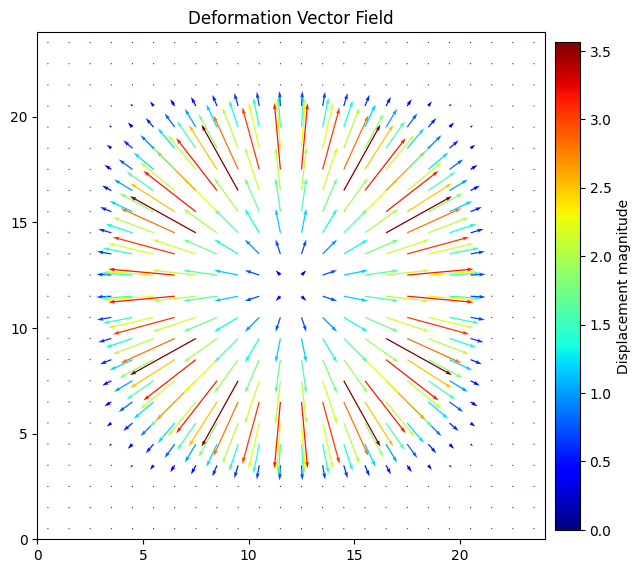

In [3]:
plot_dvf(dvf, scale=1)
plt.title("Deformation Vector Field")
# np.save('01.npy', dvf)

In [4]:
dvf_rmse(dvf, np.zeros_like(dvf))

0.48595795

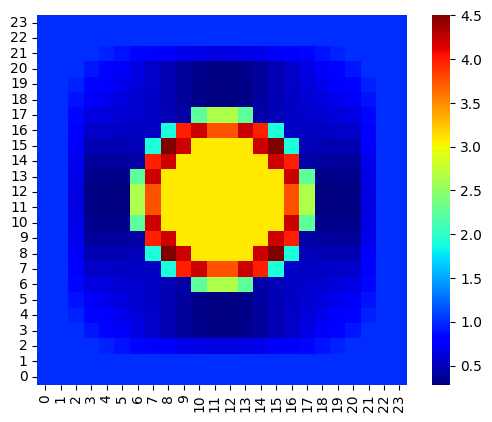

In [5]:
jac_det = jacobian_determinant(dvf)

In [6]:
np.min(jac_det), np.max(jac_det)

(0.28290036, 4.5038524)

In [15]:
reference_image = sitk.ReadImage(INSTANCES_SRC / 'synthetic' / 'scans' / '01_Fixed.mhd')
moving_image = sitk.ReadImage(INSTANCES_SRC / 'synthetic' / 'scans' / '01_Moving.mhd')
dvf_img = sitk.GetImageFromArray(np.swapaxes(dvf, 0, 2).astype(np.float64), isVector=True)
displacement_transform = sitk.DisplacementFieldTransform(dvf_img)
moving_deformed = sitk.Resample(moving_image, reference_image, displacement_transform, sitk.sitkNearestNeighbor, 0.0, moving_image.GetPixelID())
deformed = sitk.GetArrayFromImage(moving_deformed)
deformed = np.swapaxes(deformed, 0, 2)
# sitk.WriteImage(moving_deformed, INSTANCES_SRC / 'synthetic' / 'scans' / '01_Fixed.mhd')

In [14]:
np.sum(fixed != deformed)

0

In [198]:
# # Bending energy calculation using interpolation

# from joblib import Parallel, delayed
# import numdifftools as nd
# from interp3d import interp_3d
# from tqdm import tqdm

# def get_hessians_numdiff(dvf):
#   hessians = []
#   for dim in range(len(dvf.shape)-1):
#       dvf_slice = dvf[..., dim]
#       max_indices = np.array(dvf_slice.shape) - 1
#       dvf_mapping = lambda x: dvf_slice[tuple(np.clip(x.astype(int), 0, max_indices))]
#       hessian = nd.Hessian(dvf_mapping, step=1)
#       hessians.append(hessian)
#   return hessians

# def bending_energy_numdiff(dvf):
#   sum = 0.0
#   hessians = get_hessians_numdiff(dvf)
#   for p in np.ndindex(dvf.shape[:-1]):
#     for dim in range(len(dvf.shape)-1):
#       sum += np.square(np.linalg.norm(hessians[dim](p)))
#   return sum / np.prod(dvf.shape[:-1])

# def hessian(grid_interpolator, p, delta):
#   p = np.array(p)
#   try:
#     grid_interpolator(p)
#   except ValueError:
#     print(f"Point {p} is out of bounds")
#     return None

#   n = len(p)
#   output = np.matrix(np.zeros(n*n))
#   output = output.reshape(n,n)
#   max_indices = [grid_interpolator.max_x, grid_interpolator.max_y, grid_interpolator.max_z]
  
#   for i in range(n):
#     for j in range(i+1):
#       ei = np.zeros(n)
#       ei[i] = 1
#       ej = np.zeros(n)
#       ej[j] = 1
#       f1 = grid_interpolator(np.clip(p + delta * ei + delta * ej, 0, max_indices))
#       f2 = grid_interpolator(np.clip(p + delta * ei - delta * ej, 0, max_indices))
#       f3 = grid_interpolator(np.clip(p - delta * ei + delta * ej, 0, max_indices))
#       f4 = grid_interpolator(np.clip(p - delta * ei - delta * ej, 0, max_indices))
#       numdiff = (f1-f2-f3+f4)/(4*delta*delta)
#       output[i,j] = numdiff
#       output[j,i] = numdiff
#   return output

# def bending_energy_point(interpolator, p, delta):
#   return np.square(np.linalg.norm(hessian(interpolator, p, delta)))

# def bending_energy(dvf, delta=0.333):
#   n = np.prod(dvf.shape[:-1])

#   x = np.arange(dvf.shape[0])
#   y = np.arange(dvf.shape[1])
#   z = np.arange(dvf.shape[2])
#   sum = 0.0

#   for dim in range(len(dvf.shape)-1):
#     dvf_slice = np.copy(dvf[..., dim], order='C').astype(np.float64)
#     fn = interp_3d.Interp3D(dvf_slice, x,y,z)
#     results = ProgressParallel(n_jobs=16, total=n)(delayed(bending_energy_point)(fn, p, delta) for p in np.ndindex(dvf.shape[:-1]))
#     sum += np.sum(results)

#   return sum / np.prod(dvf.shape[:-1])